# Import Packages

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from plot3D import *
from utils import *
from model import *

# Load the vectors 

In [2]:
with h5py.File("./full_dataset_vectors.h5", "r") as hf:    
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]
    
X_train = rgb_data_transform(X_train)
X_test = rgb_data_transform(X_test)

# Create Datasets and Dataloaders

In [3]:
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(targets_train).long()
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(targets_test).long()

batch_size = 2000

train_ds = torch.utils.data.TensorDataset(train_x,train_y)
test_ds = torch.utils.data.TensorDataset(test_x,test_y)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

# Define Hyperparameters

In [4]:
num_epochs = 160

model = CNNModel()
# model = LinearModel()
model = model.cuda()

error = nn.CrossEntropyLoss()

learning_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,0.005,0.1,cycle_momentum=False)

# Show Model Summary

In [5]:
from torchsummary import summary
summary(model,(3,16,16,16),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [2000, 8, 14, 14, 14]             656
            Conv3d-2     [2000, 32, 12, 12, 12]           6,944
         MaxPool3d-3        [2000, 32, 3, 3, 3]               0
            Conv3d-4        [2000, 32, 1, 1, 1]          27,680
       BatchNorm3d-5        [2000, 32, 1, 1, 1]              64
           Dropout-6                 [2000, 32]               0
            Linear-7                 [2000, 10]             330
Total params: 35,674
Trainable params: 35,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 93.75
Forward/backward pass size (MB): 1193.51
Params size (MB): 0.14
Estimated Total Size (MB): 1287.40
----------------------------------------------------------------


# Train the Model

In [6]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for epoch in range(num_epochs):
    model.train()
    running_acc = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):     
        train = Variable(images.permute(0,4,1,2,3)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        train_loss+=loss.data
        train_accuracy = accuracy_score(torch.argmax(outputs,axis = 1).cpu().numpy(),labels.cpu().numpy())
        running_acc+=train_accuracy*len(images)
        loss.backward()
        optimizer.step()
#         scheduler.step()
    running_acc/=len(train_ds)
    train_loss/=5
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            test = Variable(images.permute(0,4,1,2,3)).cuda()
            outputs = model(test).detach()
            test_loss = error(outputs,labels.cuda())
            test_accuracy = accuracy_score(torch.argmax(outputs,axis = 1).cpu().numpy(),labels.cpu().numpy())
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss.data)
    test_accuracy_list.append(test_accuracy)
    train_accuracy_list.append(train_accuracy)
    

    print('Epoch: {}  Train Loss:{:.2f}, Test Loss:{:.2f}, Train Accuracy:{:.2f}, Test Accuracy:{:.2f}'.format(epoch, train_loss,test_loss,train_accuracy,test_accuracy))


Epoch: 0  Train Loss:2.53, Test Loss:2.32, Train Accuracy:0.11, Test Accuracy:0.10
Epoch: 1  Train Loss:2.45, Test Loss:2.31, Train Accuracy:0.13, Test Accuracy:0.12
Epoch: 2  Train Loss:2.38, Test Loss:2.30, Train Accuracy:0.16, Test Accuracy:0.13
Epoch: 3  Train Loss:2.32, Test Loss:2.28, Train Accuracy:0.19, Test Accuracy:0.16
Epoch: 4  Train Loss:2.26, Test Loss:2.26, Train Accuracy:0.21, Test Accuracy:0.18
Epoch: 5  Train Loss:2.22, Test Loss:2.23, Train Accuracy:0.23, Test Accuracy:0.23
Epoch: 6  Train Loss:2.17, Test Loss:2.20, Train Accuracy:0.26, Test Accuracy:0.28
Epoch: 7  Train Loss:2.13, Test Loss:2.15, Train Accuracy:0.26, Test Accuracy:0.30
Epoch: 8  Train Loss:2.11, Test Loss:2.10, Train Accuracy:0.27, Test Accuracy:0.31
Epoch: 9  Train Loss:2.07, Test Loss:2.05, Train Accuracy:0.30, Test Accuracy:0.33
Epoch: 10  Train Loss:2.04, Test Loss:2.00, Train Accuracy:0.31, Test Accuracy:0.33
Epoch: 11  Train Loss:2.01, Test Loss:1.95, Train Accuracy:0.33, Test Accuracy:0.34
Ep

Epoch: 98  Train Loss:1.27, Test Loss:1.25, Train Accuracy:0.61, Test Accuracy:0.62
Epoch: 99  Train Loss:1.27, Test Loss:1.24, Train Accuracy:0.60, Test Accuracy:0.62
Epoch: 100  Train Loss:1.26, Test Loss:1.24, Train Accuracy:0.61, Test Accuracy:0.61
Epoch: 101  Train Loss:1.25, Test Loss:1.24, Train Accuracy:0.62, Test Accuracy:0.62
Epoch: 102  Train Loss:1.25, Test Loss:1.24, Train Accuracy:0.62, Test Accuracy:0.62
Epoch: 103  Train Loss:1.25, Test Loss:1.24, Train Accuracy:0.62, Test Accuracy:0.62
Epoch: 104  Train Loss:1.25, Test Loss:1.24, Train Accuracy:0.62, Test Accuracy:0.62
Epoch: 105  Train Loss:1.24, Test Loss:1.24, Train Accuracy:0.62, Test Accuracy:0.62
Epoch: 106  Train Loss:1.24, Test Loss:1.24, Train Accuracy:0.61, Test Accuracy:0.62
Epoch: 107  Train Loss:1.24, Test Loss:1.24, Train Accuracy:0.63, Test Accuracy:0.62
Epoch: 108  Train Loss:1.24, Test Loss:1.23, Train Accuracy:0.62, Test Accuracy:0.62
Epoch: 109  Train Loss:1.23, Test Loss:1.23, Train Accuracy:0.61, T

# Test the Model

In [7]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        test = Variable(images.permute(0,4,1,2,3)).cuda()
        outputs = model(test).detach()
        test_loss = error(outputs,labels.cuda())
        test_accuracy = accuracy_score(torch.argmax(outputs,axis = 1).cpu().numpy(),labels.cpu().numpy())
print(test_accuracy)
torch.save(model.state_dict,'./CNN_5e-5.pth')

0.6495


# Generate Plots

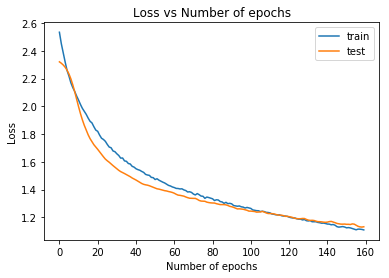

In [8]:
plt.plot(train_loss_list,label = 'train')
plt.plot(test_loss_list,label = 'test')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

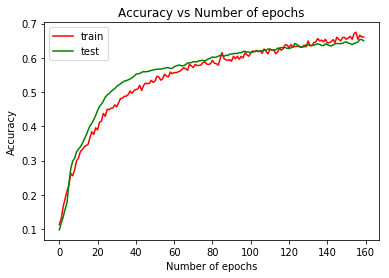

In [9]:
plt.plot(train_accuracy_list,color = "red",label = 'train')
plt.plot(test_accuracy_list,color = "green",label = 'test')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")
plt.show()

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/3dmnist')
test = Variable(images.permute(0,4,1,2,3)).cuda()
writer.add_graph(model,test)
# writer.close()